# HN dataset play

In [2]:
import sys
import os
import h5py 
import scipy.io as sio
import pprint

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Data/'

       
import numpy as np
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
print(device)

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', 'checkpoints')

#%load_ext autoreload
#%autoreload 2

Running on Computer: [PFC]
cuda:0
Save_dir = checkpoints


In [3]:
import NTdatasets.HN.HNdatasets as datasets

num_lags = 12

inclMUs = True #set false for now
fn = 'ki_0503_V2a_py.mat'
data = datasets.HNdataset(filename=fn, datadir=datadir, drift_interval=90)
print(len(data), data.NC)

./Data/ ki_0503_V2a_py.mat
Loaded ki_0503_V2a_py.mat
118679 frames, 29 units, 848 trials with 116 frames each
118679 29


In [4]:
# This is the data that is (clumsily) loaded into the dataset object
matdat = sio.loadmat('./Data/ki_0503_V2a_py.mat')
matdat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'CHnamesV2', 'CHnamesV3', 'cued', 'choice', 'signal', 'strength', 'cued_stim', 'Robs', 'moduvar', 'Xsacc', 'used_inds', 'stimL', 'stimR', 'blks', 'disp_list', 'Dc_list', 'CHnames'])

In [5]:
## 10 ms resolution (~200 frames in each trial)
print('\nHere is the data (stims on both sides and response):')
print(data.robs.shape, data.stimL.shape, data.stimR.shape)
print('These stims are stored as numpy arrays in the data structure as 1-hot, corresponding to the disparity list:')
print(data.disp_list)
print('\nUsually the left stimulus is in the RF.')

print('\nHere are the indices associated with each trial:')
print(data.Ntr, len(data.block_inds))

# Trial resolution -- aggregating neural responses across whole trial
print('\nBelow is a list of trial-level information:')
print('  Spike counts over trial for each neuron:', data.Rtr.shape )
# direction of 'added signal' (near=-1, far=+1) in RF and outside RF
print('\n  Added signal direction for left and right sides (-1=near, +1=far):', data.TRsignal.shape )
print('  Added signal strength for left and right sides (-1=near, +1=far):', data.TRstrength.shape )
print('\n  Which side was cued (in RF=1, out of RF=-1):', data.TRcued.shape)
# Decision on each trial
print('\n  Decision (-1 or +1):', data.TRchoice.shape)


Here is the data (stims on both sides and response):
torch.Size([118679, 29]) (118679, 11) (118679, 11)
These stims are stored as numpy arrays in the data structure as 1-hot, corresponding to the disparity list:
[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]

Usually the left stimulus is in the RF.

Here are the indices associated with each trial:
848 848

Below is a list of trial-level information:
  Spike counts over trial for each neuron: (848, 29)

  Added signal direction for left and right sides (-1=near, +1=far): (848, 2)
  Added signal strength for left and right sides (-1=near, +1=far): (848, 2)

  Which side was cued (in RF=1, out of RF=-1): (848,)

  Decision (-1 or +1): (848,)


In [6]:
## Additional stimulus-processing information
print('For model-fitting, we can choose stimulus and time-embed to store in the data.stim varible')
 # this creates the stim variable
data.prepare_stim(which_stim='left', num_lags=num_lags)
print(data.stim.shape)

print('\nThe stimulus is flattened, but dimension information is in data.stim_dims')
print(data.stim_dims)
print('This is always stored by [channels, space0, space1, lags]\nIt can be reshaped as follows:' )
# All stimuli are Time embedding: its flattened, and any stimulus can reshaped using data.stim_dims
data.stim.reshape([data.NT] + data.stim_dims).shape, data.stim.reshape([-1, len(data.disp_list), num_lags]).shape

For model-fitting, we can choose stimulus and time-embed to store in the data.stim varible
torch.Size([118679, 132])

The stimulus is flattened, but dimension information is in data.stim_dims
[1, 11, 1, 12]
This is always stored by [channels, space0, space1, lags]
It can be reshaped as follows:


(torch.Size([118679, 1, 11, 1, 12]), torch.Size([118679, 11, 12]))

# Exercises

In [7]:
sorted(list(vars(data).keys()))

['CHnames',
 'MUinds',
 'NC',
 'NT',
 'Nframes',
 'Nstim',
 'Ntr',
 'Rtr',
 'SUinds',
 'TRchoice',
 'TRcued',
 'TRsignal',
 'TRstim',
 'TRstrength',
 'Utr',
 'Xdrift',
 'Xsacc',
 'Xtr',
 'anchors',
 'avRs',
 'block_filemapping',
 'block_inds',
 'cells_out',
 'datadir',
 'device',
 'dfs',
 'disp_list',
 'drift_interval',
 'filenames',
 'include_MUs',
 'num_lags',
 'num_mus',
 'num_sus',
 'num_units',
 'preload',
 'robs',
 'stim',
 'stimL',
 'stimR',
 'stim_dims',
 'stimlist',
 'sus',
 'test_inds',
 'time_embed',
 'train_inds',
 'trs',
 'used_inds',
 'val_inds']

In [8]:
data.stim.shape, data.stimL.shape, data.stim_dims

(torch.Size([118679, 132]), (118679, 11), [1, 11, 1, 12])

In [9]:
# You can use data.stim and data.robs, and should not need anything else

# Q's:
#    is each robs spiking for a particular neuron for the timestep? --> YES
#    is each robs already bucketed per the stim timestep? --> YES
#    is there a dt in the data? --> DON'T NEED IT
#    for the STA, can we convert the one-hot encoded vector as just its index? --> NO, THIS WON'T WORK

# data.stim, tuple with:
# 1) 
# 2) 

# data.robs, :
# flattened one-hot encoded list of robs for each eye for each neuron

np.where(data.stim.numpy()[0] == 1)

(array([84]),)

In [10]:
data.stimR[1]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [11]:
data.robs.shape

torch.Size([118679, 29])

In [12]:
# [0, 0, 1, 0] --> 

In [13]:
data.robs[4]

tensor([1., 1., 0., 0., 4., 1., 0., 1., 1., 2., 3., 2., 3., 4., 2., 4., 2., 4.,
        3., 3., 2., 3., 3., 4., 4., 2., 2., 1., 1.])

In [18]:
len(data.robs), len(data.stimR)

(118679, 118679)

In [19]:
data.stim.shape

torch.Size([118679, 132])

## Problem 1: calculate the forward-correlation and/or STA for each neuron

In [20]:
X = data.stim
R = data.robs
X.shape, R.shape

(torch.Size([118679, 132]), torch.Size([118679, 29]))

In [21]:
X[0].shape, X[0]
X[:,0][:10]

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [23]:
R[0].shape, R[0]

(torch.Size([29]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]))

In [24]:
X.T[0].shape

torch.Size([118679])

In [25]:
totals = np.matmul(X.T, R) # this creates the total spike count per disparity per neuron
totals.shape

torch.Size([132, 29])

In [26]:
print(X.shape, R.shape)
# sum the total spikes per lag (12 lags for 100ms) (copied over all stimulus features)
# R is spikes, 
# so we need to sum these up along the correct axis in order to be able to divide

torch.Size([118679, 132]) torch.Size([118679, 29])


In [27]:
spike_counts = np.sum(R.numpy(), axis=0)
spike_counts

array([12361., 12363.,  7844., 12868., 47736., 28386., 46610., 25568.,
       21678., 55857., 50214., 54032., 77200., 52211., 12431., 46649.,
       15545., 58240., 49033., 55327., 55291., 32516., 60031., 62017.,
       60604., 32835., 20783., 14865., 11922.], dtype=float32)

In [28]:
# TODO: divide by the (total count of spikes per column)? in order to produce an average
stas = totals / spike_counts
stas

tensor([[0.0765, 0.0847, 0.0821,  ..., 0.0843, 0.0888, 0.0868],
        [0.0823, 0.0789, 0.0774,  ..., 0.0824, 0.0854, 0.0852],
        [0.0800, 0.0768, 0.0789,  ..., 0.0818, 0.0869, 0.0832],
        ...,
        [0.0739, 0.0816, 0.0750,  ..., 0.0709, 0.0683, 0.0694],
        [0.0757, 0.0745, 0.0688,  ..., 0.0703, 0.0679, 0.0660],
        [0.0772, 0.0762, 0.0702,  ..., 0.0686, 0.0695, 0.0675]])

[]

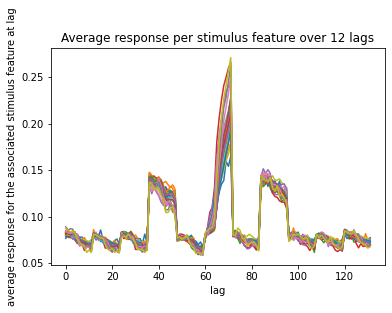

In [24]:
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot(, sta[0,:])

ax = fig.add_subplot(111)
ax.set_xlabel('lag')
ax.set_ylabel('average response for the associated stimulus feature at lag')
ax.set_title('Average response per stimulus feature over 12 lags')
for i, sta in enumerate(stas.T):
    ax.plot(sta, label='neuron ' + str(i))
plt.plot()

### apply the STA to the stims and see what the result is and compare it to the actual spikes

In [57]:
# NOTE: this might be doing something, but I am not sure yet
#filtered_stim = np.matmul(X, stas)
#plt.plot(filtered_stim[:50])

torch.Size([132, 29])


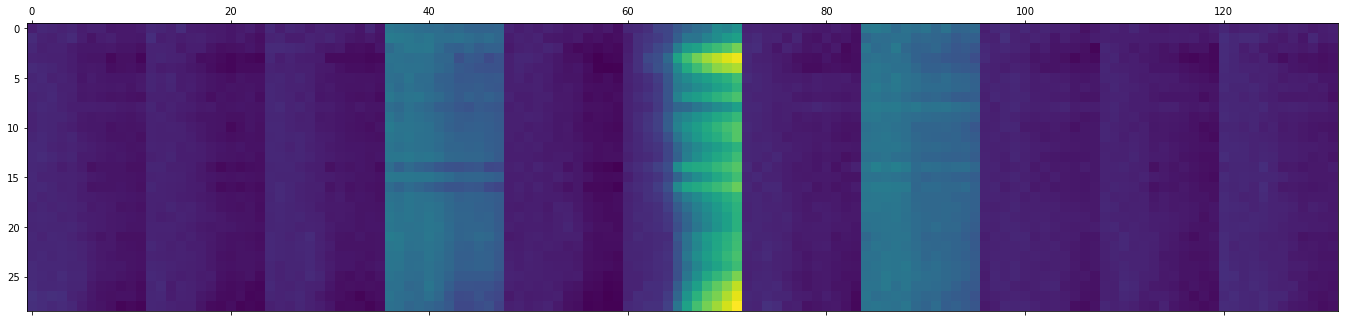

In [26]:
print(stas.shape)

# plot the spiking raster
axraster = plt.axes([1, 1, 4, 1])
axraster.matshow(stas.T) #just show the spike counts per trial
plt.show()

In [27]:
stas[:,0].shape

torch.Size([132])

torch.Size([29, 132]) torch.Size([132])


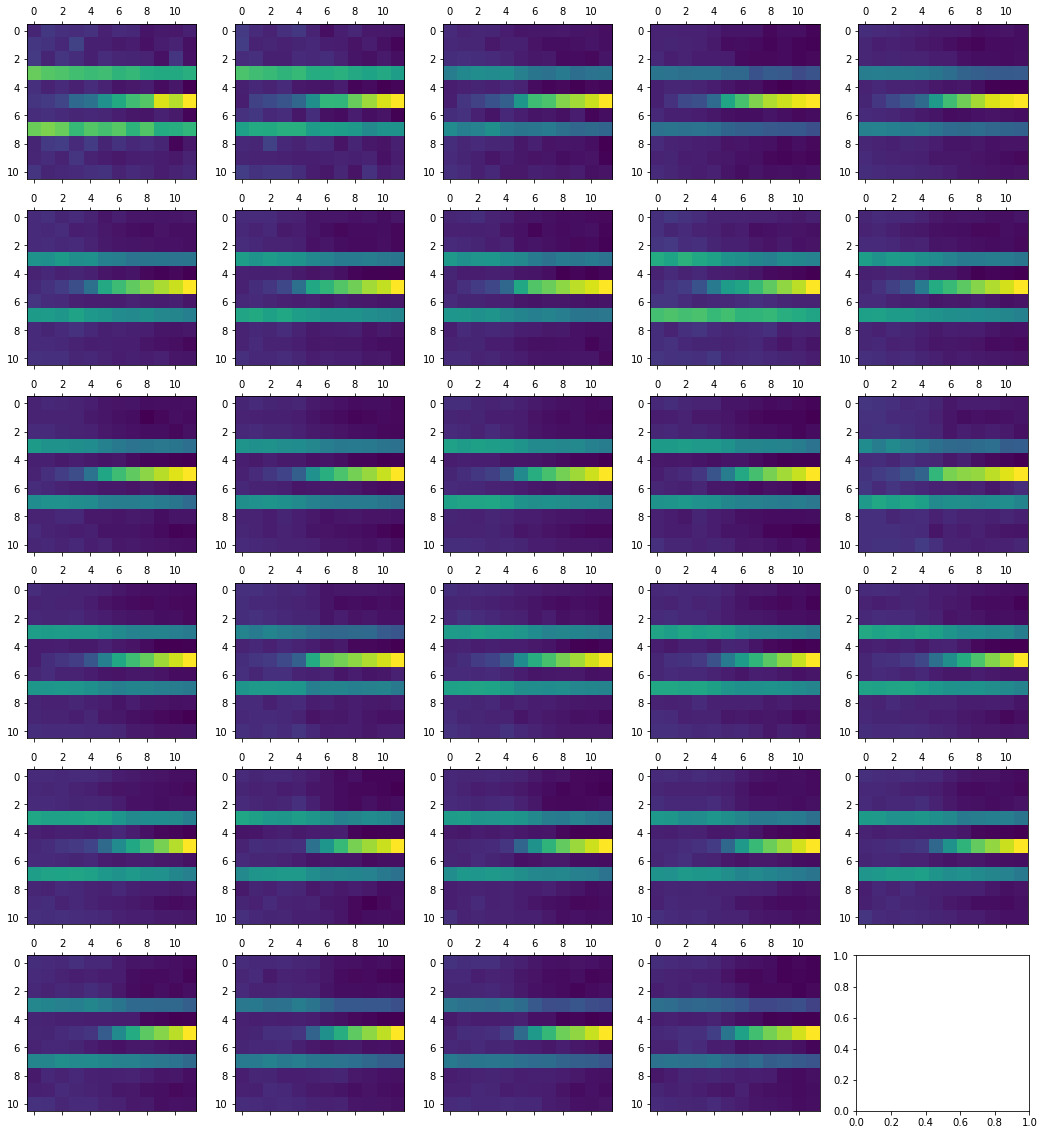

<Figure size 432x288 with 0 Axes>

In [28]:
# make a plot for each neuron and how it responds to the different disparities
print(stas.T.shape, stas.T[0].shape)

fig, ax = plt.subplots(nrows=6, ncols=5)
fig.set_size_inches(18, 20, forward=True)

figraster = plt.figure()
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        neuron_idx = i*len(row) + j
        if neuron_idx < len(stas.T): # only plot the neurons (e.g. skip plot # 30)
            # 11 rows (disparities), 12 cols (time lags)
            raster = stas.T[neuron_idx].reshape((11, 12))
            col.matshow(raster) # plot how neuron 0 responds to the different disparities

In [29]:
stas.T[0].shape

torch.Size([132])

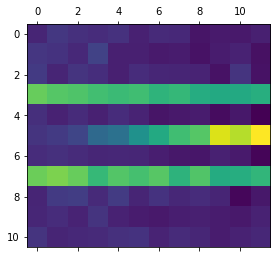

In [33]:
# Create the raster or plot of how an individual neuron responds to each disparity
NEURON = 0
# 11 rows (disparities), 12 cols (time lags)
raster = stas.T[NEURON].reshape((11, 12))
plt.matshow(raster) # plot how neuron 0 responds to the different disparities

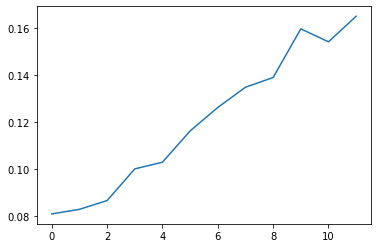

In [44]:
# Look at how the neuron responds to an indivudal disparity, and draw its tuning curve
plt.plot(stas.T[NEURON].reshape((11, 12))[5]) # at disparity 5, right in the middle

### Problem 1x: check the STA for the stimulus on the other side (stimR)

In [51]:
# You can use prepare_stim and do the same thing
# (by the "same thing", I assume to produce the time-embedding for only stimR?

# apply the STA to stimR
data.stimR.shape, data.stim.shape, stas.shape

# one-hot encode and time-embed (use prepare_stim) the stimR 
# and apply the STA to it to see what the result is
# this overwrites the stim variable
data.prepare_stim(which_stim='right', num_lags=num_lags)
print(data.stim.shape)

torch.Size([118679, 132])


In [52]:
X = data.stim
R = data.robs
X.shape, R.shape

(torch.Size([118679, 132]), torch.Size([118679, 29]))

In [53]:
totals = np.matmul(X.T, R) # this creates the total spike count per disparity per neuron
totals.shape

torch.Size([132, 29])

In [54]:
spike_counts = np.sum(R.numpy(), axis=0)
spike_counts

array([12361., 12363.,  7844., 12868., 47736., 28386., 46610., 25568.,
       21678., 55857., 50214., 54032., 77200., 52211., 12431., 46649.,
       15545., 58240., 49033., 55327., 55291., 32516., 60031., 62017.,
       60604., 32835., 20783., 14865., 11922.], dtype=float32)

In [55]:
# TODO: divide by the (total count of spikes per column)? in order to produce an average
stas = totals / spike_counts
stas

tensor([[0.0781, 0.0815, 0.0817,  ..., 0.0816, 0.0804, 0.0844],
        [0.0833, 0.0848, 0.0797,  ..., 0.0809, 0.0791, 0.0794],
        [0.0809, 0.0844, 0.0827,  ..., 0.0810, 0.0815, 0.0835],
        ...,
        [0.0747, 0.0696, 0.0697,  ..., 0.0680, 0.0683, 0.0691],
        [0.0756, 0.0696, 0.0677,  ..., 0.0654, 0.0660, 0.0632],
        [0.0769, 0.0703, 0.0688,  ..., 0.0630, 0.0607, 0.0625]])

[]

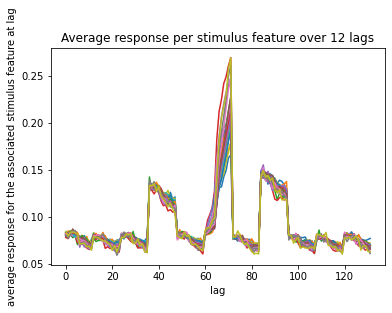

In [56]:
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot(, sta[0,:])

ax = fig.add_subplot(111)
ax.set_xlabel('lag')
ax.set_ylabel('average response for the associated stimulus feature at lag')
ax.set_title('Average response per stimulus feature over 12 lags')
for i, sta in enumerate(stas.T):
    ax.plot(sta, label='neuron ' + str(i))
plt.plot()

torch.Size([132, 29])


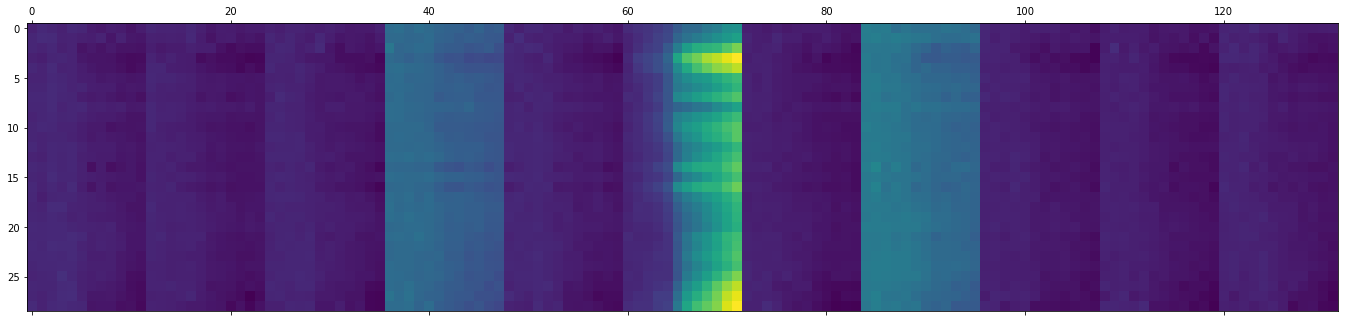

In [58]:
print(stas.shape)

# plot the spiking raster
axraster = plt.axes([1, 1, 4, 1])
axraster.matshow(stas.T) #just show the spike counts per trial
plt.show()

torch.Size([29, 132]) torch.Size([132])


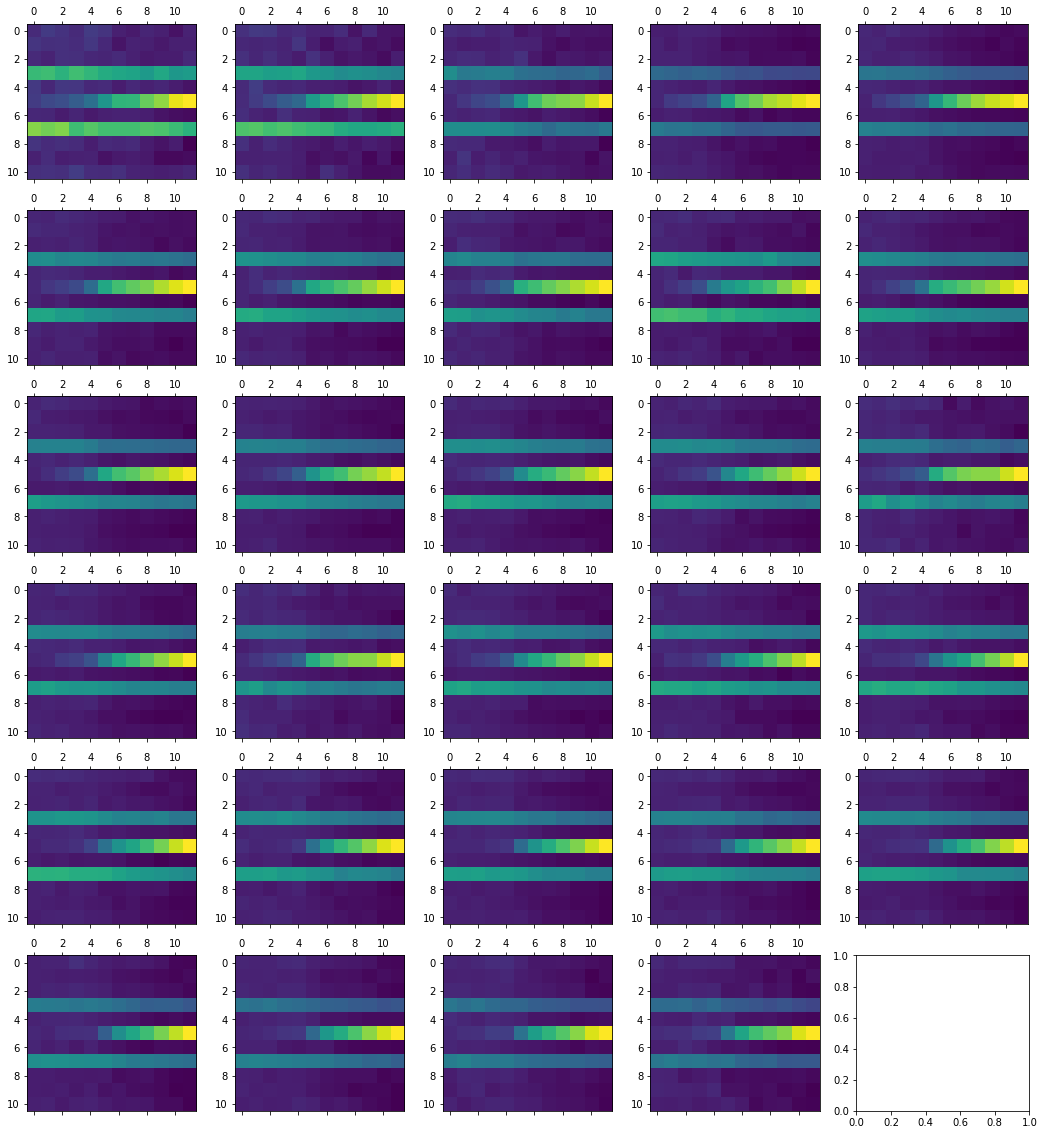

<Figure size 432x288 with 0 Axes>

In [59]:
# make a plot for each neuron and how it responds to the different disparities
print(stas.T.shape, stas.T[0].shape)

fig, ax = plt.subplots(nrows=6, ncols=5)
fig.set_size_inches(18, 20, forward=True)

figraster = plt.figure()
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        neuron_idx = i*len(row) + j
        if neuron_idx < len(stas.T): # only plot the neurons (e.g. skip plot # 30)
            # 11 rows (disparities), 12 cols (time lags)
            raster = stas.T[neuron_idx].reshape((11, 12))
            col.matshow(raster) # plot how neuron 0 responds to the different disparities

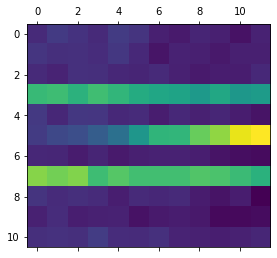

In [60]:
# Create the raster or plot of how an individual neuron responds to each disparity
NEURON = 0
# 11 rows (disparities), 12 cols (time lags)
raster = stas.T[NEURON].reshape((11, 12))
plt.matshow(raster) # plot how neuron 0 responds to the different disparities

## Problem 3: trial-level: compute the psychophysical curve

In [32]:
# This is a plot of the fraction of correct responses as a function of signal strength 
# You should need: TRstim, TRstr, TRcued, and TRchoice

# TODO: this seems orthogonal to the STA calculation,
#       but I think it's just a matter of munging and then dividing some stuff

# the prefix TR must mean TRial, for each trial

# TODO: what is signal strength? is it the amount of binocular disparity?

```
Below is a list of trial-level information:
Spike counts over trial for each neuron: (848, 29)

Added signal direction for left and right sides (-1=near, +1=far): (848, 2)
Added signal strength for left and right sides (-1=near, +1=far): (848, 2)

Which side was cued (in RF=1, out of RF=-1): (848,)

Decision (-1 or +1): (848,)
```

In [70]:
# signal direction?
print("Signal Direction", data.TRstim.shape)

# signal strength?
print("Signal Strength", data.TRstrength.shape)

# which field to look at, left or right.
print("Correct Response", data.TRcued.shape)

# actual response?
print("Actual Response", data.TRchoice.shape)

Signal Direction (848, 2)
Signal Strength (848, 2)
Correct Response (848,)
Actual Response (848,)


In [71]:
data.TRstim[:10]

array([[-0.07,  0.27],
       [ 0.27,  0.  ],
       [ 0.07, -0.27],
       [-0.27, -0.  ],
       [ 0.07, -0.07],
       [ 0.27, -0.07],
       [ 0.  ,  0.27],
       [ 0.07,  0.  ],
       [ 0.07, -0.  ],
       [-0.27, -0.  ]])

In [72]:
data.TRstrength[:10]

array([[0.07, 0.27],
       [0.27, 0.  ],
       [0.07, 0.27],
       [0.27, 0.  ],
       [0.07, 0.07],
       [0.27, 0.07],
       [0.  , 0.27],
       [0.07, 0.  ],
       [0.07, 0.  ],
       [0.27, 0.  ]])